## Parsed Events History

Notebook exploring how to read in parsed events history (peh) struct from matlab saved as a 32 bit blob in data joint into python. This structure contains timing information from the state machine in three categories: pokes, sates, and waves.

Using code from Alvaro's tutorial notebook https://github.com/Brody-Lab/bl_pipeline_python/blob/main/notebooks/tutorials/Read_blob_Sessions.ipynb

In [81]:
import datajoint as dj
import blob_transformation as bt
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from peh_utils import *

import pandas as pd

dj.blob.use_32bit_dims = True
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
bdata = dj.create_virtual_module('new_acquisition', 'bdatatest')
session_key = {'sessid': 881918}
peh_blob = (bdata.ParsedEvents & session_key).fetch(as_dict=True)

[2022-09-19 14:47:25,820][INFO]: Connecting jbreda@datajoint01.pni.princeton.edu:3306
[2022-09-19 14:47:26,494][INFO]: Connected jbreda@datajoint01.pni.princeton.edu:3306


In [4]:
n_sessions = 1
peh_dict = bt.transform_blob(peh_blob[n_sessions-1]['peh'])
n_trials = len(peh_dict)

### Pokes

In [5]:
itrial = 0

peh_dict[itrial]['pokes']

{'C': array([[498.043904, 498.140904],
        [504.694404, 504.848804],
        [505.149804, 505.187504]]),
 'L': array([[496.349804, 496.529304],
        [496.548704, 496.734404],
        [496.804004, 497.236404],
        [499.535904, 499.686704],
        [503.657904, 504.344204]]),
 'R': array([[498.539004, 499.202904],
        [505.425804, 505.920504]]),
 'starting_state': {'C': 'out', 'L': 'out', 'R': 'out'},
 'ending_state': {'C': 'out', 'L': 'out', 'R': 'out'}}

### States

In [6]:
peh_dict[itrial]['states'].keys()

dict_keys(['state_0', 'check_next_trial_ready', 'wait_for_cpoke', 'cpoke', 'wait_for_sounds_to_end', 'early_spoke_state', 'give_reward', 'wait_for_spoke', 'hit_state', 'drink_state', 'temp_error_state', 'wait_for_spoke_retry', 'retry_hit_state', 'error_state', 'violation_state', 'violation_penalty_state', 'general_final_state', 'hit_final_state', 'error_final_state', 'violation_final_state', 'starting_state', 'ending_state'])

In [58]:
peh_dict[itrial]['states']['hit_state'].size

0

In [88]:

keys = ['t_start', 't_end', 'cpoke_in', 'cpoke_out', 'spoke_in']
peh_trials_dict = {key : (np.nan * np.ones((n_trials))) for key in keys }

for it in range(n_trials):
    
    # renaming to keep the lines of code shorter
    trial_states = peh_dict[it]['states']
    trial_pokes = peh_dict[it]['pokes']

    # trial start and end time indicated by state 0 for all protocols
    peh_trials_dict['t_start'][it] = trial_states['state_0'][0][1]
    peh_trials_dict['t_end'][it] = trial_states['state_0'][1][0]

    # cpoke that initiated the trial
    peh_trials_dict['cpoke_in'][it], peh_trials_dict['cpoke_out'][it] = fetch_trial_start_cpoke(trial_states)
    # first spoke after trial initialization
    peh_trials_dict['spoke_in'][it] = fetch_first_spoke(trial_states)
    

(array([204.,  13.,   6.,   4.,   1.,  34.,   1.,   2.,   2.,   3.]),
 array([0.7002 , 0.75918, 0.81816, 0.87714, 0.93612, 0.9951 , 1.05408,
        1.11306, 1.17204, 1.23102, 1.29   ]),
 <BarContainer object of 10 artists>)

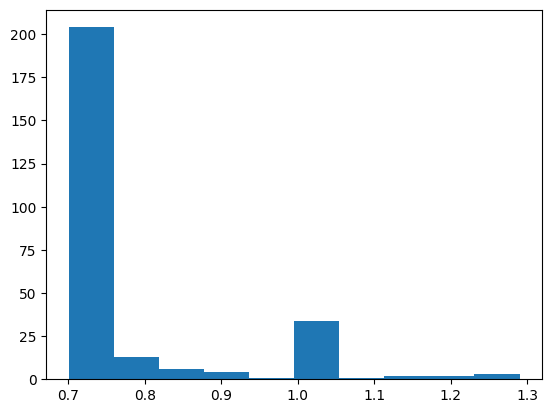

In [90]:
plt.hist(peh_trials_dict['spoke_in'] - peh_trials_dict['cpoke_in'])

### Waves

In [ ]:
peh[itrial]

In [47]:
type(peh_dict[itrial]['waves'])

dict

##### Checking if empty

In [35]:
len(peh_dict[itrial]['states']['early_spoke_state'])

0

In [38]:
peh_dict[itrial]['states'].get('early_spoke_state').size

0

In [76]:
peh_dict[1]['states']['cpoke'].size

2

In [53]:
peh_dict[itrial]['states']['wait_for_spoke'][1]

505.42580399999997

#### average early spoke time

In [81]:
time_to_side_poke = []
trial_length = []

for itrial in range(n_trials):
    spoke_time = peh_dict[itrial]['states']['wait_for_spoke'][1]
    if peh_dict[itrial]['states']['cpoke'].size > 2:
        cpoke_time = peh_dict[itrial]['states']['cpoke'][-1][0]
    else:
        cpoke_time = peh_dict[itrial]['states']['cpoke'][0]
    gosound_time = peh_dict[itrial]['waves']['go_sound_wave'][0]
    time_to_side_poke.append(spoke_time - cpoke_time)
    trial_length.append(gosound_time- cpoke_time)

time_to_side_poke = np.array(time_to_side_poke)
trial_length = np.array(trial_length)



In [82]:
diff = trial_length - time_to_side_poke

(array([204.,  13.,   6.,   4.,   1.,  34.,   1.,   2.,   2.,   3.]),
 array([0.7002 , 0.75918, 0.81816, 0.87714, 0.93612, 0.9951 , 1.05408,
        1.11306, 1.17204, 1.23102, 1.29   ]),
 <BarContainer object of 10 artists>)

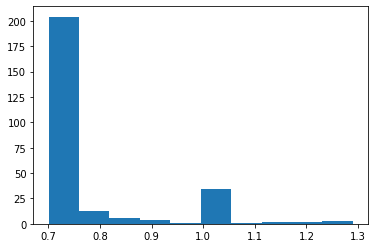

In [85]:
plt.hist(time_to_side_poke)

### Waves

In [43]:
peh_dict[itrial]['waves'].keys()

dict_keys(['cp_fixation_wave', 'sa_sound_wave', 'sb_sound_wave', 'go_sound_wave', 'starting_state', 'ending_state'])

In [54]:
peh_dict[itrial]['waves']['cp_fixation_wave']

array([], shape=(0, 2), dtype=float64)

In [56]:
for i in range(n_trials):
    print(peh_dict[itrial]['waves']['go_sound_wave'][0])


505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404